In [1]:
import numpy as np   # numercal python. 수치 해석
import pandas as pd   # DataFrame을 쉽게 다루기

import matplotlib.pyplot as plt   # Data visualization
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 5
import seaborn as sns   # Data visualization
sns.set(font_scale = 2.0)   # seaborn 라이브러리 세팅 (plot의 모든 폰트 사이즈를 2.0로 지정)
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')   # ignore warning

In [2]:
dt = pd.read_csv('./03_oil_value_ts.csv')
dt.head(10)

Code Statistics        Fuel Type Sulfur Content Viscosity Delivery Type  \
0  PPXDK00      CLOSE         Fuel Oil           3.5%   380 CST           FOB   
1  PUABC00      CLOSE         Fuel Oil           3.5%   Unknown           FOB   
2  PUAFT00      CLOSE  Bunker Fuel Oil        Unknown   380 CST     Delivered   
3  AALMZ00      CLOSE    Marine Gasoil           0.5%   Unknown     Delivered   
4  PUAFN00      CLOSE  Bunker Fuel Oil           3.5%   380 CST     Delivered   
5  AAYWT00      CLOSE           Gasoil           0.1%   Unknown           FOB   
6  AARTG00      CLOSE    Marine Gasoil           0.1%   Unknown     Delivered   
7  AARKD00      CLOSE  Bunker Fuel Oil        Unknown   380 CST     Delivered   
8  AARKE00      CLOSE    Marine Gasoil           0.5%   Unknown     Delivered   
9  PUAFL00      CLOSE  Bunker Fuel Oil           3.5%   380 CST     Delivered   

    Location              Country Continent  2022-01-04  ...  2024-04-09  \
0  Singapore            Singapore      Asia      434.04  ...       491.9   
1  Rotterdam          Netherlands    Europe      430.50  ...       474.0   
2  Singapore            Singapore      Asia      447.00  ...       507.0   
3  Singapore            Singapore      Asia      684.00  ...       810.0   
4  Rotterdam          Netherlands    Europe      439.00  ...       475.0   
5  ARA Barge  Netherlands/Belgium    Europe      672.25  ...       816.0   
6  Rotterdam          Netherlands    Europe      670.00  ...       805.0   
7   Shanghai                China      Asia      505.00  ...       504.0   
8   Shanghai                China      Asia      785.00  ...       850.0   
9    Piraeus               Greece    Europe      468.00  ...       540.0   

   2024-04-10  2024-04-11  2024-04-12  2024-04-15  2024-04-16  2024-04-17  \
0     490.855      489.81      492.18      490.35      500.33      500.50   
1     466.750      472.50      479.00      472.00      485.00      482.75   
2     506.000      505.00      507.00      505.00      507.00      512.00   
3     810.000      810.00      803.00      798.00      805.00      801.00   
4     468.000      472.00      496.00      474.00      486.00      483.00   
5     801.250      800.50      816.75      794.00      795.50      784.75   
6     797.000      800.00      805.00      790.00      790.00      780.00   
7     504.500      505.00      510.00      507.00      518.00      521.00   
8     850.000      850.00      846.00      840.00      845.00      845.00   
9     535.000      535.00      535.00      540.00      535.00      540.00   

   2024-04-18  2024-04-19  2024-04-22  
0      495.32      499.21      489.36  
1      477.00      472.75      467.50  
2      509.00      513.00      507.00  
3      765.00      763.00      760.00  
4      477.00      476.00      469.00  
5      756.75      759.00      758.50  
6      760.00      750.00      750.00  
7      519.00      523.00      517.00  
8      833.00      825.00      820.00  
9      540.00      540.00      540.00  

[10 rows x 604 columns]

In [3]:
dt = dt[dt['Statistics'] == 'CLOSE'].drop(['Code', 'Viscosity'], axis=1)

In [4]:
dt['Fuel Type'] = dt['Fuel Type'] + ' ' + (dt.groupby('Fuel Type').cumcount() + 1).astype(str)
dt

Statistics          Fuel Type Sulfur Content Delivery Type   Location  \
0       CLOSE         Fuel Oil 1           3.5%           FOB  Singapore   
1       CLOSE         Fuel Oil 2           3.5%           FOB  Rotterdam   
2       CLOSE  Bunker Fuel Oil 1        Unknown     Delivered  Singapore   
3       CLOSE    Marine Gasoil 1           0.5%     Delivered  Singapore   
4       CLOSE  Bunker Fuel Oil 2           3.5%     Delivered  Rotterdam   
..        ...                ...            ...           ...        ...   
86      CLOSE         Fuel Oil 5           3.5%           CIF  Med Cargo   
89      CLOSE           Gasoil 6           0.1%           CIF  Med Cargo   
92      CLOSE           Gasoil 7           0.1%           CIF  NWE Cargo   
94      CLOSE      Marine Fuel 3           0.5%     Delivered     Santos   
95      CLOSE   Marine Gasoil 37           0.1%     Delivered     Santos   

              Country      Continent  2022-01-04  2022-01-05  2022-01-06  ...  \
0           Singapore           Asia      434.04      436.28      438.37  ...   
1         Netherlands         Europe      430.50      437.75      444.00  ...   
2           Singapore           Asia      447.00      449.00      451.00  ...   
3           Singapore           Asia      684.00      694.00      698.00  ...   
4         Netherlands         Europe      439.00      445.00      456.00  ...   
..                ...            ...         ...         ...         ...  ...   
86      Mediterranean         Europe      436.00      442.00      449.75  ...   
89      Mediterranean         Europe      690.50      706.75      715.25  ...   
92  North West Europe         Europe         NaN         NaN         NaN  ...   
94             Brazil  South America         NaN         NaN         NaN  ...   
95             Brazil  South America         NaN         NaN         NaN  ...   

    2024-04-09  2024-04-10  2024-04-11  2024-04-12  2024-04-15  2024-04-16  \
0       491.90     490.855      489.81      492.18      490.35      500.33   
1       474.00     466.750      472.50      479.00      472.00      485.00   
2       507.00     506.000      505.00      507.00      505.00      507.00   
3       810.00     810.000      810.00      803.00      798.00      805.00   
4       475.00     468.000      472.00      496.00      474.00      486.00   
..         ...         ...         ...         ...         ...         ...   
86      493.50     491.250      498.25      505.50      498.50      506.00   
89      835.75     831.000      830.50      846.00      822.25      821.75   
92      821.25     813.250      813.00      829.00      806.25      808.00   
94      676.00     677.000      670.00      672.00      668.00      670.00   
95      914.00     917.000      912.00      915.00      905.00      904.00   

    2024-04-17  2024-04-18  2024-04-19  2024-04-22  
0       500.50      495.32      499.21      489.36  
1       482.75      477.00      472.75      467.50  
2       512.00      509.00      513.00      507.00  
3       801.00      765.00      763.00      760.00  
4       483.00      477.00      476.00      469.00  
..         ...         ...         ...         ...  
86      501.75      496.00      492.00      487.75  
89      810.75      779.00      781.00      783.00  
92      797.50      770.50      773.00      772.25  
94      664.00      659.00      661.00      649.00  
95      900.00      896.00      899.00      884.00  

[82 rows x 602 columns]

In [5]:
# 시계열 데이터 분석을 위해 transpose
dt_columns = dt.columns[7:]
ts = dt.set_index(['Fuel Type', 'Sulfur Content', 'Delivery Type', 'Location', 'Country', 'Continent'])[dt_columns]
ts = ts.T
ts

Fuel Type      Fuel Oil 1  Fuel Oil 2 Bunker Fuel Oil 1 Marine Gasoil 1  \
Sulfur Content       3.5%        3.5%           Unknown            0.5%   
Delivery Type         FOB         FOB         Delivered       Delivered   
Location        Singapore   Rotterdam         Singapore       Singapore   
Country         Singapore Netherlands         Singapore       Singapore   
Continent            Asia      Europe              Asia            Asia   
2022-01-04         434.04      430.50             447.0           684.0   
2022-01-05         436.28      437.75             449.0           694.0   
2022-01-06         438.37      444.00             451.0           698.0   
2022-01-07         450.78      442.00             463.0           709.0   
2022-01-10         448.57      437.25             461.0           712.0   
...                   ...         ...               ...             ...   
2024-04-16         500.33      485.00             507.0           805.0   
2024-04-17         500.50      482.75             512.0           801.0   
2024-04-18         495.32      477.00             509.0           765.0   
2024-04-19         499.21      472.75             513.0           763.0   
2024-04-22         489.36      467.50             507.0           760.0   

Fuel Type      Bunker Fuel Oil 2            Gasoil 1 Marine Gasoil 2  \
Sulfur Content              3.5%                0.1%            0.1%   
Delivery Type          Delivered                 FOB       Delivered   
Location               Rotterdam           ARA Barge       Rotterdam   
Country              Netherlands Netherlands/Belgium     Netherlands   
Continent                 Europe              Europe          Europe   
2022-01-04                 439.0              672.25           670.0   
2022-01-05                 445.0              692.25           685.0   
2022-01-06                 456.0              701.25           703.0   
2022-01-07                 456.0              702.25           700.0   
2022-01-10                 451.0              698.75           702.0   
...                          ...                 ...             ...   
2024-04-16                 486.0              795.50           790.0   
2024-04-17                 483.0              784.75           780.0   
2024-04-18                 477.0              756.75           760.0   
2024-04-19                 476.0              759.00           750.0   
2024-04-22                 469.0              758.50           750.0   

Fuel Type      Bunker Fuel Oil 3 Marine Gasoil 3 Bunker Fuel Oil 4  ...  \
Sulfur Content           Unknown            0.5%              3.5%  ...   
Delivery Type          Delivered       Delivered         Delivered  ...   
Location                Shanghai        Shanghai           Piraeus  ...   
Country                    China           China            Greece  ...   
Continent                   Asia            Asia            Europe  ...   
2022-01-04                 505.0           785.0             468.0  ...   
2022-01-05                 508.0           785.0             470.0  ...   
2022-01-06                 510.0           785.0             473.0  ...   
2022-01-07                 520.0           797.0             475.0  ...   
2022-01-10                 515.0           790.0             479.0  ...   
...                          ...             ...               ...  ...   
2024-04-16                 518.0           845.0             535.0  ...   
2024-04-17                 521.0           845.0             540.0  ...   
2024-04-18                 519.0           833.0             540.0  ...   
2024-04-19                 523.0           825.0             540.0  ...   
2024-04-22                 517.0           820.0             540.0  ...   

Fuel Type      Marine Fuel 2 Bunker Fuel Oil 28 Marine Gasoil 36  \
Sulfur Content          0.5%               3.5%             0.1%   
Delivery Type            CIF          Delivered        Delivered   
Location           

In [6]:
ts.isna().sum()

Fuel Type          Sulfur Content  Delivery Type  Location   Country            Continent    
Fuel Oil 1         3.5%            FOB            Singapore  Singapore          Asia               0
Fuel Oil 2         3.5%            FOB            Rotterdam  Netherlands        Europe             0
Bunker Fuel Oil 1  Unknown         Delivered      Singapore  Singapore          Asia               0
Marine Gasoil 1    0.5%            Delivered      Singapore  Singapore          Asia               0
Bunker Fuel Oil 2  3.5%            Delivered      Rotterdam  Netherlands        Europe             0
                                                                                                ... 
Fuel Oil 5         3.5%            CIF            Med Cargo  Mediterranean      Europe             0
Gasoil 6           0.1%            CIF            Med Cargo  Mediterranean      Europe             0
Gasoil 7           0.1%            CIF            NWE Cargo  North West Europe  Europe            

In [7]:
# 결측치 컬럼 삭제
ts = ts.iloc[:, :-3]
ts

Fuel Type      Fuel Oil 1  Fuel Oil 2 Bunker Fuel Oil 1 Marine Gasoil 1  \
Sulfur Content       3.5%        3.5%           Unknown            0.5%   
Delivery Type         FOB         FOB         Delivered       Delivered   
Location        Singapore   Rotterdam         Singapore       Singapore   
Country         Singapore Netherlands         Singapore       Singapore   
Continent            Asia      Europe              Asia            Asia   
2022-01-04         434.04      430.50             447.0           684.0   
2022-01-05         436.28      437.75             449.0           694.0   
2022-01-06         438.37      444.00             451.0           698.0   
2022-01-07         450.78      442.00             463.0           709.0   
2022-01-10         448.57      437.25             461.0           712.0   
...                   ...         ...               ...             ...   
2024-04-16         500.33      485.00             507.0           805.0   
2024-04-17         500.50      482.75             512.0           801.0   
2024-04-18         495.32      477.00             509.0           765.0   
2024-04-19         499.21      472.75             513.0           763.0   
2024-04-22         489.36      467.50             507.0           760.0   

Fuel Type      Bunker Fuel Oil 2            Gasoil 1 Marine Gasoil 2  \
Sulfur Content              3.5%                0.1%            0.1%   
Delivery Type          Delivered                 FOB       Delivered   
Location               Rotterdam           ARA Barge       Rotterdam   
Country              Netherlands Netherlands/Belgium     Netherlands   
Continent                 Europe              Europe          Europe   
2022-01-04                 439.0              672.25           670.0   
2022-01-05                 445.0              692.25           685.0   
2022-01-06                 456.0              701.25           703.0   
2022-01-07                 456.0              702.25           700.0   
2022-01-10                 451.0              698.75           702.0   
...                          ...                 ...             ...   
2024-04-16                 486.0              795.50           790.0   
2024-04-17                 483.0              784.75           780.0   
2024-04-18                 477.0              756.75           760.0   
2024-04-19                 476.0              759.00           750.0   
2024-04-22                 469.0              758.50           750.0   

Fuel Type      Bunker Fuel Oil 3 Marine Gasoil 3 Bunker Fuel Oil 4  ...  \
Sulfur Content           Unknown            0.5%              3.5%  ...   
Delivery Type          Delivered       Delivered         Delivered  ...   
Location                Shanghai        Shanghai           Piraeus  ...   
Country                    China           China            Greece  ...   
Continent                   Asia            Asia            Europe  ...   
2022-01-04                 505.0           785.0             468.0  ...   
2022-01-05                 508.0           785.0             470.0  ...   
2022-01-06                 510.0           785.0             473.0  ...   
2022-01-07                 520.0           797.0             475.0  ...   
2022-01-10                 515.0           790.0             479.0  ...   
...                          ...             ...               ...  ...   
2024-04-16                 518.0           845.0             535.0  ...   
2024-04-17                 521.0           845.0             540.0  ...   
2024-04-18                 519.0           833.0             540.0  ...   
2024-04-19                 523.0           825.0             540.0  ...   
2024-04-22                 517.0           820.0             540.0  ...   

Fuel Type      Marine Gasoil 34 Marine Gasoil 35 Marine Fuel 1 Marine Fuel 2  \
Sulfur Content             0.1%             0.1%          0.5%          0.5%   
Delivery Type         Delivered        Delivered           FOB 

# 1. Marine Gasoil

In [9]:
dt_fuel_mg = ts.filter(regex='Marine Gasoil')
dt_fuel_mg

Fuel Type      Marine Gasoil 1 Marine Gasoil 2 Marine Gasoil 3  \
Sulfur Content            0.5%            0.1%            0.5%   
Delivery Type        Delivered       Delivered       Delivered   
Location             Singapore       Rotterdam        Shanghai   
Country              Singapore     Netherlands           China   
Continent                 Asia          Europe            Asia   
2022-01-04               684.0           670.0           785.0   
2022-01-05               694.0           685.0           785.0   
2022-01-06               698.0           703.0           785.0   
2022-01-07               709.0           700.0           797.0   
2022-01-10               712.0           702.0           790.0   
...                        ...             ...             ...   
2024-04-16               805.0           790.0           845.0   
2024-04-17               801.0           780.0           845.0   
2024-04-18               765.0           760.0           833.0   
2024-04-19               763.0           750.0           825.0   
2024-04-22               760.0           750.0           820.0   

Fuel Type      Marine Gasoil 4 Marine Gasoil 5 Marine Gasoil 6  \
Sulfur Content            0.1%            0.1%            0.1%   
Delivery Type        Delivered       Delivered        Ex-Wharf   
Location               Piraeus       Hong Kong           Genoa   
Country                 Greece           China           Italy   
Continent               Europe            Asia          Europe   
2022-01-04               701.0           700.0           735.0   
2022-01-05               710.0           705.0           755.0   
2022-01-06               711.0           709.0           760.0   
2022-01-07               720.0           715.0           770.0   
2022-01-10               720.0           718.0           795.0   
...                        ...             ...             ...   
2024-04-16               880.0           808.0           900.0   
2024-04-17               875.0           808.0           900.0   
2024-04-18               865.0           782.0           890.0   
2024-04-19               855.0           772.0           875.0   
2024-04-22               847.0           772.0           875.0   

Fuel Type      Marine Gasoil 7 Marine Gasoil 8 Marine Gasoil 9  \
Sulfur Content            0.5%            0.1%            0.1%   
Delivery Type        Delivered       Delivered       Delivered   
Location                 Busan      Charleston     Los Angeles   
Country            South Korea   United States   United States   
Continent                 Asia   North America   North America   
2022-01-04              708.25           777.0           775.5   
2022-01-05              722.25           778.0           800.5   
2022-01-06              715.00           785.0           802.5   
2022-01-07              733.00           786.0           806.5   
2022-01-10              736.00           792.0           813.5   
...                        ...             ...             ...   
2024-04-16              816.50           911.0           876.5   
2024-04-17              814.50           893.0           865.5   
2024-04-18              799.50           883.0           859.5   
2024-04-19              792.50           884.0           860.5   
2024-04-22              792.25           887.0           861.5   

Fuel Type      Marine Gasoil 10  ... Marine Gasoil 27 Marine Gasoil 28  \
Sulfur Content             0.1%  ...             0.1%             0.1%   
Delivery Type          Ex-Wharf  ...         Ex-Wharf        Delivered   
Location            Los Angeles  ...    San Francisco    San Francisco   
Country           United States  ...    United States    United States   
Continent         North America  ...    North America    North America   
2022-01-04                757.0  ...            797.0            809.0   
2022-01-05                782.0  ...            822.0            834.0   
2022-01-06                784.0  ...   

In [31]:
# 첫 번째 조건에 맞는 컬럼 필터링
cond1 = dt_fuel_mg.filter(regex='0.1%').columns

# 두 번째 조건에 맞는 컬럼 필터링
cond2 = dt_fuel_mg.filter(regex='Delivered').columns

# 세 번째 조건에 맞는 컬럼 필터링
cond3 = dt_fuel_mg.filter(regex='United States').columns

# 각 조건을 모두 만족하는 컬럼 찾기 (교집합)
common_columns = cond1.intersection(cond2).intersection(cond3)

# 해당 컬럼만 선택
dt_fuel_mg_cond1 = dt_fuel_mg[common_columns]
dt_fuel_mg_cond1

Fuel Type      Marine Gasoil 8 Marine Gasoil 9 Marine Gasoil 11  \
Sulfur Content            0.1%            0.1%             0.1%   
Delivery Type        Delivered       Delivered        Delivered   
Location            Charleston     Los Angeles          Houston   
Country          United States   United States    United States   
Continent        North America   North America    North America   
2022-01-04               777.0           775.5            733.0   
2022-01-05               778.0           800.5            740.0   
2022-01-06               785.0           802.5            750.0   
2022-01-07               786.0           806.5            751.0   
2022-01-10               792.0           813.5            758.0   
...                        ...             ...              ...   
2024-04-16               911.0           876.5            824.0   
2024-04-17               893.0           865.5            818.0   
2024-04-18               883.0           859.5            800.0   
2024-04-19               884.0           860.5            802.0   
2024-04-22               887.0           861.5            800.0   

Fuel Type      Marine Gasoil 12 Marine Gasoil 13 Marine Gasoil 15  \
Sulfur Content             0.1%             0.1%             0.1%   
Delivery Type         Delivered        Delivered        Delivered   
Location               New York          Norfolk          Seattle   
Country           United States    United States    United States   
Continent         North America    North America    North America   
2022-01-04                733.0            738.0            853.0   
2022-01-05                739.0            764.0            864.0   
2022-01-06                743.0            771.0            879.0   
2022-01-07                744.0            772.0            889.0   
2022-01-10                760.0            781.0            900.0   
...                         ...              ...              ...   
2024-04-16                847.0            924.0            858.0   
2024-04-17                843.0            920.0            847.0   
2024-04-18                837.0            914.0            838.0   
2024-04-19                824.0            887.0            839.0   
2024-04-22                813.0            889.0            840.0   

Fuel Type      Marine Gasoil 28  
Sulfur Content             0.1%  
Delivery Type         Delivered  
Location          San Francisco  
Country           United States  
Continent         North America  
2022-01-04                809.0  
2022-01-05                834.0  
2022-01-06                836.0  
2022-01-07                840.0  
2022-01-10                847.0  
...                         ...  
2024-04-16                881.0  
2024-04-17                870.0  
2024-04-18                864.0  
2024-04-19                865.0  
2024-04-22                866.0  

[595 rows x 7 columns]

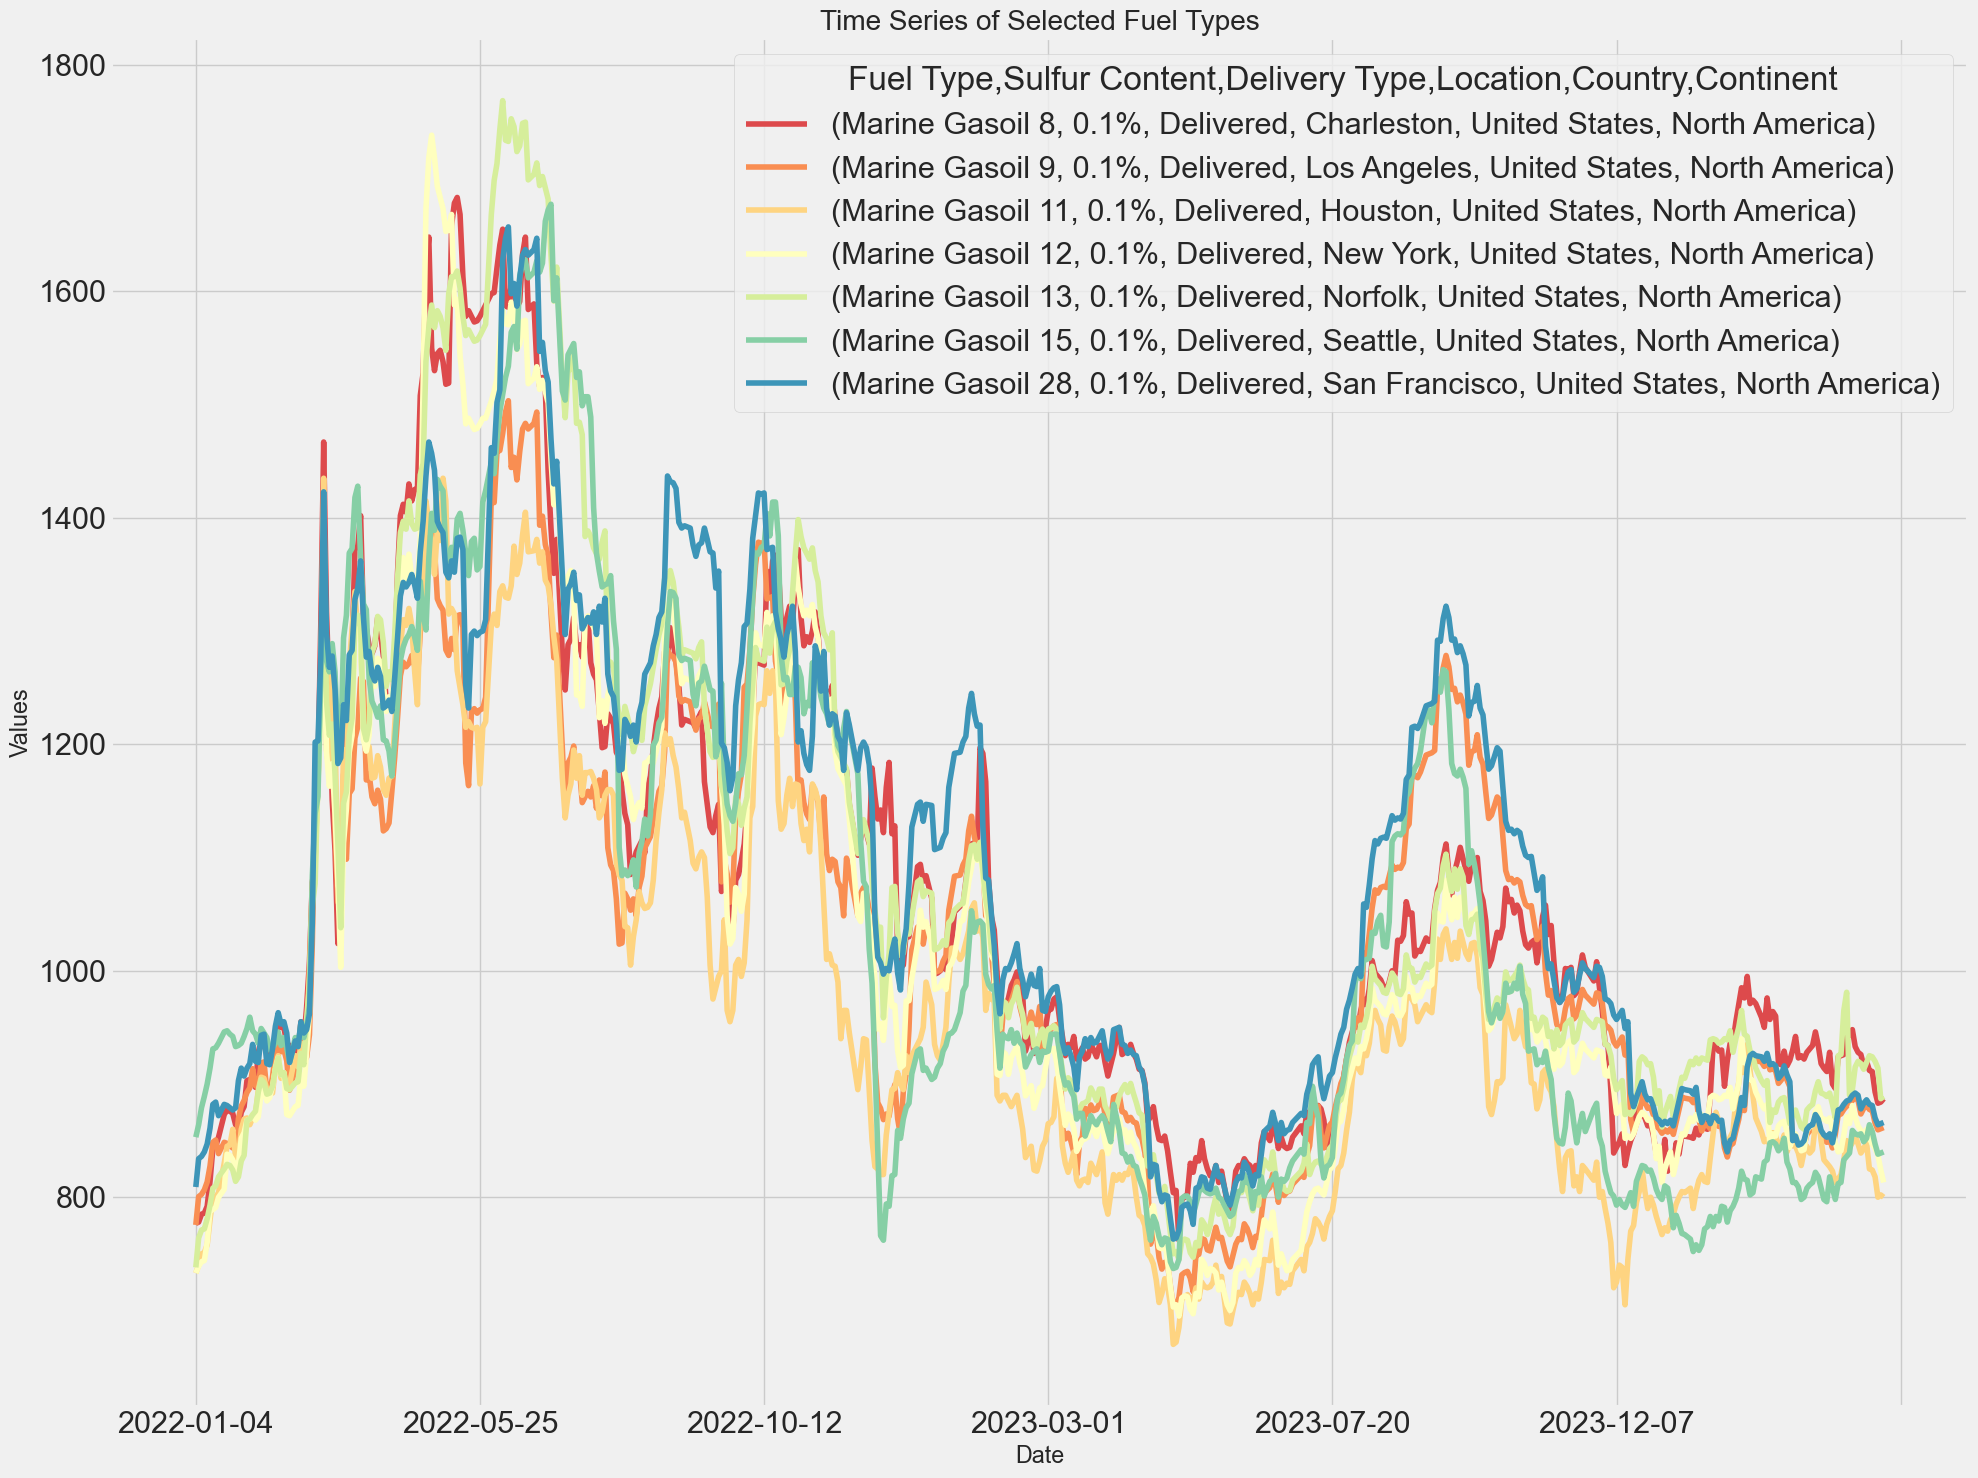

In [34]:
# Set plot parameters
sns.set_palette("Spectral", len(dt_fuel_mg_cond1.columns))
plt.rcParams['figure.figsize'] = (20, 15)

# Plot each column in a single plot
ax = dt_fuel_mg_cond1.plot(legend=True)

# Set title and labels
ax.set_title('Time Series of Selected Fuel Types')
ax.set_xlabel('Date')
ax.set_ylabel('Values')

# Show plot
plt.tight_layout()
plt.show()

In [42]:
# 첫 번째 조건에 맞는 컬럼 필터링
cond1 = dt_fuel_mg.filter(regex='0.1%').columns

# 두 번째 조건에 맞는 컬럼 필터링
cond2 = dt_fuel_mg.filter(regex='Delivered').columns

# 세 번째 조건에 맞는 컬럼 필터링
cond3 = dt_fuel_mg.filter(regex='Europe').columns

# 각 조건을 모두 만족하는 컬럼 찾기 (교집합)
common_columns = cond1.intersection(cond2).intersection(cond3)

# 해당 컬럼만 선택
dt_fuel_mg_cond2 = dt_fuel_mg[common_columns]
dt_fuel_mg_cond2

Fuel Type      Marine Gasoil 2 Marine Gasoil 4 Marine Gasoil 16  \
Sulfur Content            0.1%            0.1%             0.1%   
Delivery Type        Delivered       Delivered        Delivered   
Location             Rotterdam         Piraeus        Gibraltar   
Country            Netherlands          Greece Gibraltar Strait   
Continent               Europe          Europe           Europe   
2022-01-04               670.0           701.0            713.0   
2022-01-05               685.0           710.0            727.0   
2022-01-06               703.0           711.0            747.0   
2022-01-07               700.0           720.0            749.0   
2022-01-10               702.0           720.0            750.0   
...                        ...             ...              ...   
2024-04-16               790.0           880.0            865.0   
2024-04-17               780.0           875.0            860.0   
2024-04-18               760.0           865.0            850.0   
2024-04-19               750.0           855.0            840.0   
2024-04-22               750.0           847.0            825.0   

Fuel Type      Marine Gasoil 29 Marine Gasoil 30 Marine Gasoil 31  \
Sulfur Content             0.1%             0.1%             0.1%   
Delivery Type         Delivered        Delivered        Delivered   
Location               Istanbul        Algeciras          Antwerp   
Country                  Turkey            Spain          Belgium   
Continent           Asia/Europe           Europe           Europe   
2022-01-04                754.0            713.0            670.0   
2022-01-05                762.0            727.0            685.0   
2022-01-06                773.0            747.0            703.0   
2022-01-07                768.0            749.0            700.0   
2022-01-10                775.0            750.0            702.0   
...                         ...              ...              ...   
2024-04-16                900.0            865.0            790.0   
2024-04-17                890.0            860.0            780.0   
2024-04-18                880.0            850.0            760.0   
2024-04-19                878.0            840.0            750.0   
2024-04-22                870.0            825.0            750.0   

Fuel Type      Marine Gasoil 33 Marine Gasoil 34 Marine Gasoil 35  \
Sulfur Content             0.1%             0.1%             0.1%   
Delivery Type         Delivered        Delivered        Delivered   
Location                Hamburg       Gothenburg    St Petersburg   
Country                 Germany           Sweden           Russia   
Continent                Europe           Europe      Asia/Europe   
2022-01-04                702.0            699.0            705.0   
2022-01-05                715.0            715.0            705.0   
2022-01-06                733.0            734.0            705.0   
2022-01-07                727.0            725.0            705.0   
2022-01-10                725.0            735.0            710.0   
...                         ...              ...              ...   
2024-04-16                870.0            860.0            717.0   
2024-04-17                870.0            850.0            717.0   
2024-04-18                840.0            835.0            716.0   
2024-04-19                830.0            855.0            717.0   
2024-04-22                810.0            825.0            690.0   

Fuel Type      Marine Gasoil 36  
Sulfur Content             0.1%  
Delivery Type         Delivered  
Location                  Malta  
Country                   Malta  
Continent                Europe  
2022-01-04                715.0  
2022-01-05                720.0  
2022-01-06                730.0  
2022-01-07                740.0  
2022-01-10                740.0  
...                         ...  
2024-04-16                853.0  
2024-04-17                850.0  
2024-04-18                830.0  
20

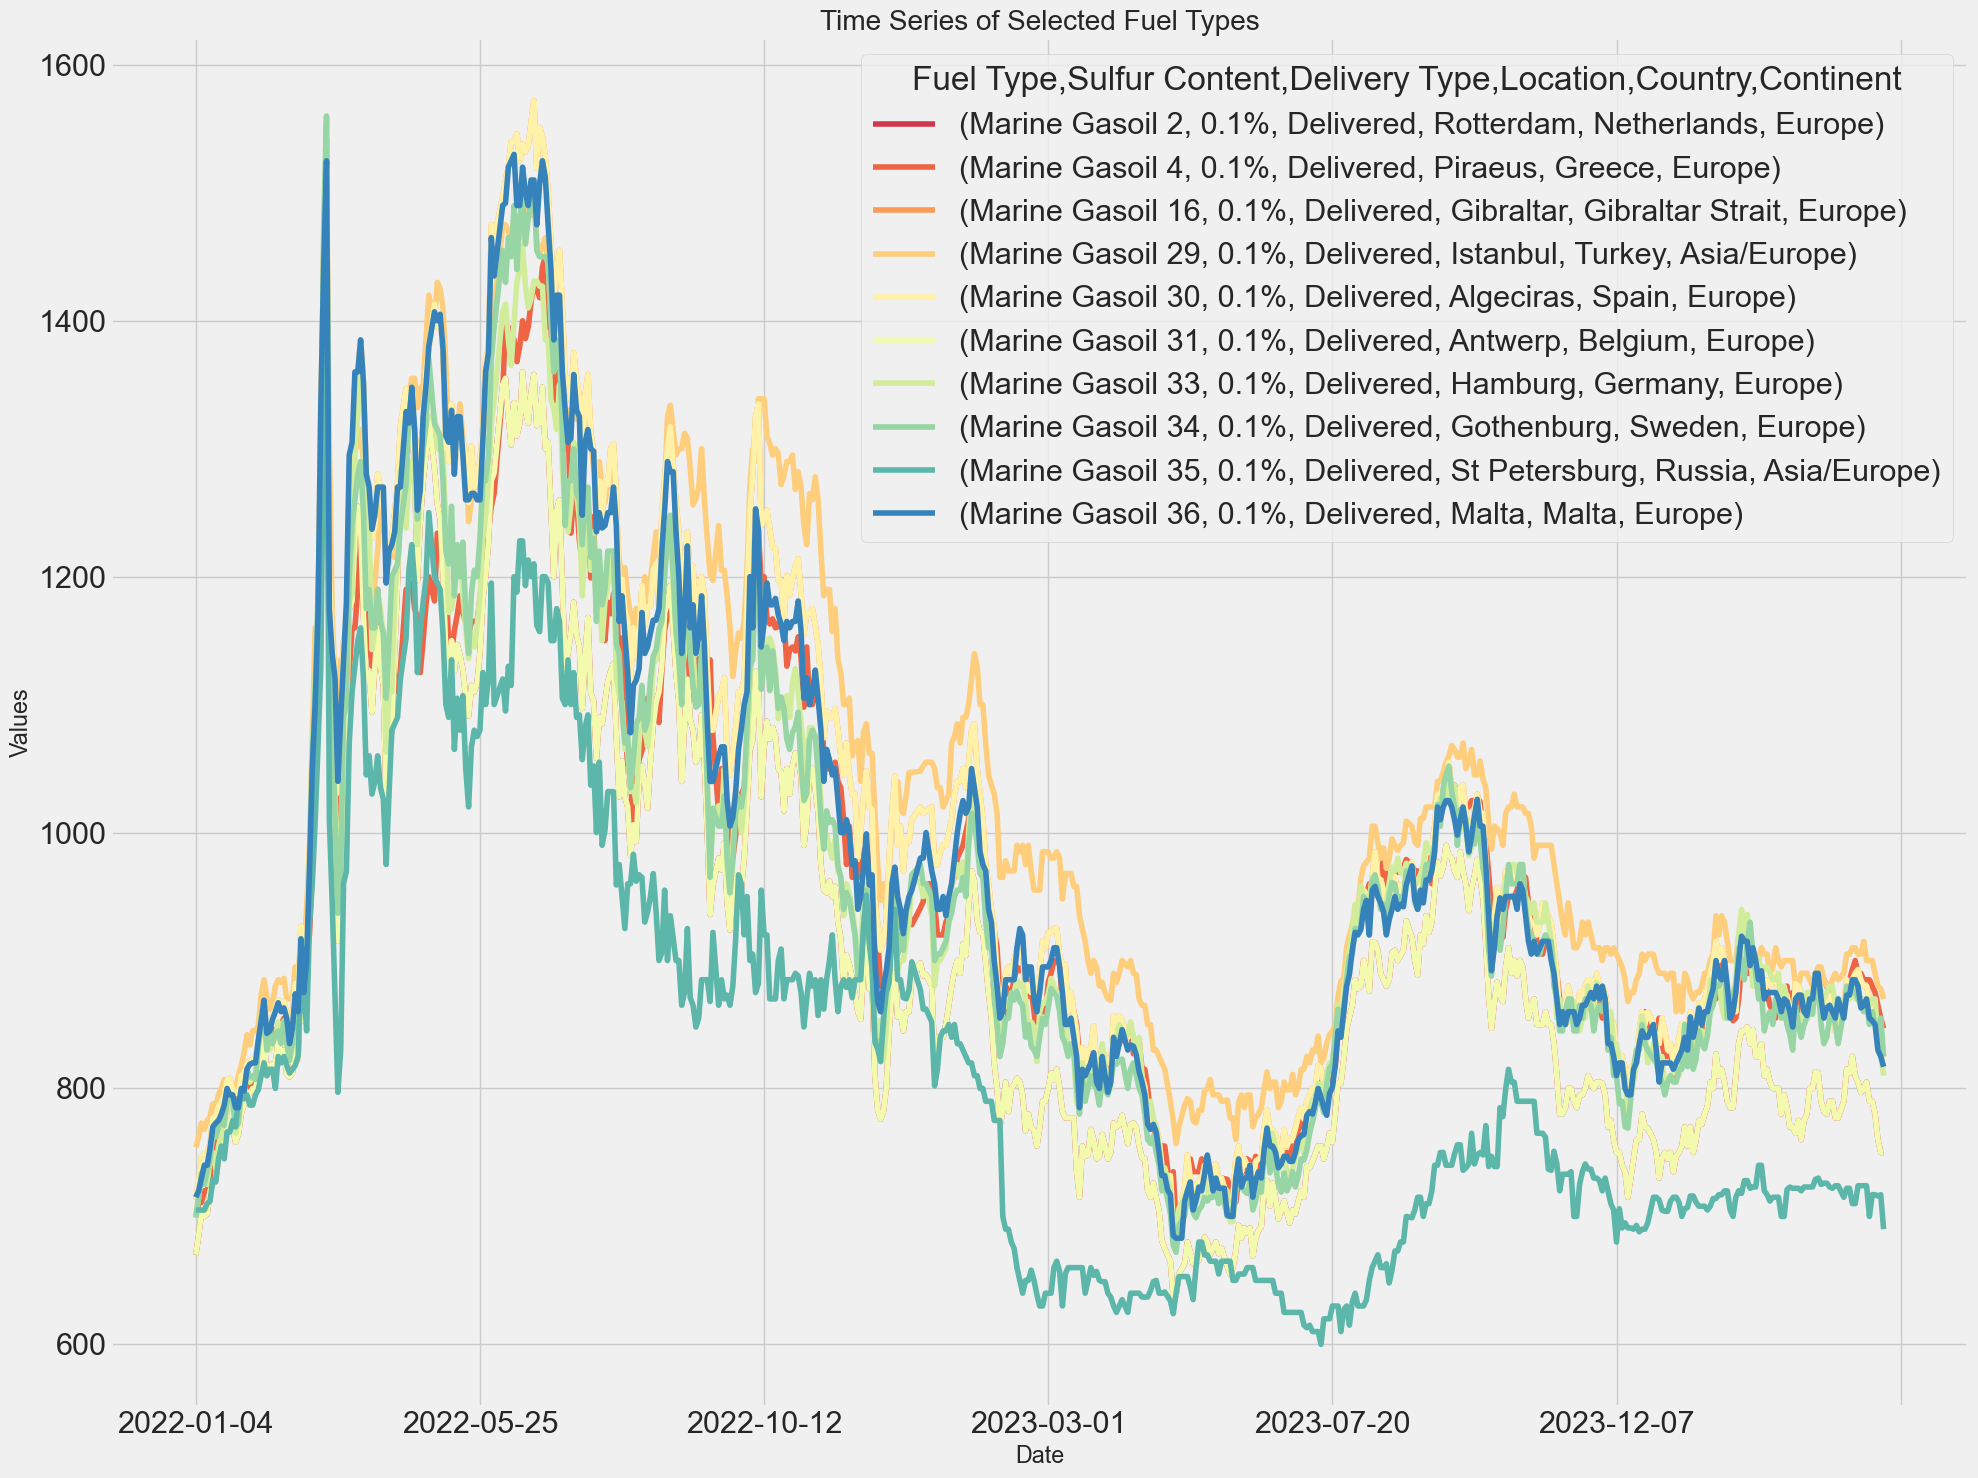

In [44]:
# Set plot parameters
sns.set_palette("Spectral", len(dt_fuel_mg_cond2.columns))
plt.rcParams['figure.figsize'] = (20, 15)

# Plot each column in a single plot
ax = dt_fuel_mg_cond2.plot(legend=True)

# Set title and labels
ax.set_title('Time Series of Selected Fuel Types')
ax.set_xlabel('Date')
ax.set_ylabel('Values')

# Show plot
plt.tight_layout()
plt.show()

In [47]:
# 첫 번째 조건에 맞는 컬럼 필터링
cond1 = dt_fuel_mg.filter(regex='0.1%').columns

# 두 번째 조건에 맞는 컬럼 필터링
cond2 = dt_fuel_mg.filter(regex='Delivered').columns

# 세 번째 조건에 맞는 컬럼 필터링
cond3 = dt_fuel_mg.filter(regex='Asia').columns

# 각 조건을 모두 만족하는 컬럼 찾기 (교집합)
common_columns = cond1.intersection(cond2).intersection(cond3)

# 해당 컬럼만 선택
dt_fuel_mg_cond3 = dt_fuel_mg[common_columns]
dt_fuel_mg_cond3

Fuel Type      Marine Gasoil 5 Marine Gasoil 22 Marine Gasoil 23  \
Sulfur Content            0.1%             0.1%             0.1%   
Delivery Type        Delivered        Delivered        Delivered   
Location             Hong Kong        Singapore         Shanghai   
Country                  China        Singapore            China   
Continent                 Asia             Asia             Asia   
2022-01-04               700.0            685.0            790.0   
2022-01-05               705.0            695.0            790.0   
2022-01-06               709.0            699.0            790.0   
2022-01-07               715.0            710.0            802.0   
2022-01-10               718.0            713.0            795.0   
...                        ...              ...              ...   
2024-04-16               808.0            810.5            855.0   
2024-04-17               808.0            806.5            855.0   
2024-04-18               782.0            770.5            843.0   
2024-04-19               772.0            768.5            835.0   
2024-04-22               772.0            765.0            830.0   

Fuel Type      Marine Gasoil 24 Marine Gasoil 29     Marine Gasoil 32  \
Sulfur Content             0.1%             0.1%                 0.1%   
Delivery Type         Delivered        Delivered            Delivered   
Location            South Korea         Istanbul             Fujairah   
Country             South Korea           Turkey United Arab Emirates   
Continent                  Asia      Asia/Europe                 Asia   
2022-01-04               708.50            754.0                775.0   
2022-01-05               722.50            762.0                770.0   
2022-01-06               720.00            773.0                770.0   
2022-01-07               734.00            768.0                780.0   
2022-01-10               736.25            775.0                785.0   
...                         ...              ...                  ...   
2024-04-16               816.75            900.0                890.0   
2024-04-17               814.75            890.0                894.0   
2024-04-18               799.75            880.0                885.0   
2024-04-19               792.75            878.0                880.0   
2024-04-22               792.50            870.0                885.0   

Fuel Type      Marine Gasoil 35  
Sulfur Content             0.1%  
Delivery Type         Delivered  
Location          St Petersburg  
Country                  Russia  
Continent           Asia/Europe  
2022-01-04                705.0  
2022-01-05                705.0  
2022-01-06                705.0  
2022-01-07                705.0  
2022-01-10                710.0  
...                         ...  
2024-04-16                717.0  
2024-04-17                717.0  
2024-04-18                716.0  
2024-04-19                717.0  
2024-04-22                690.0  

[595 rows x 7 columns]

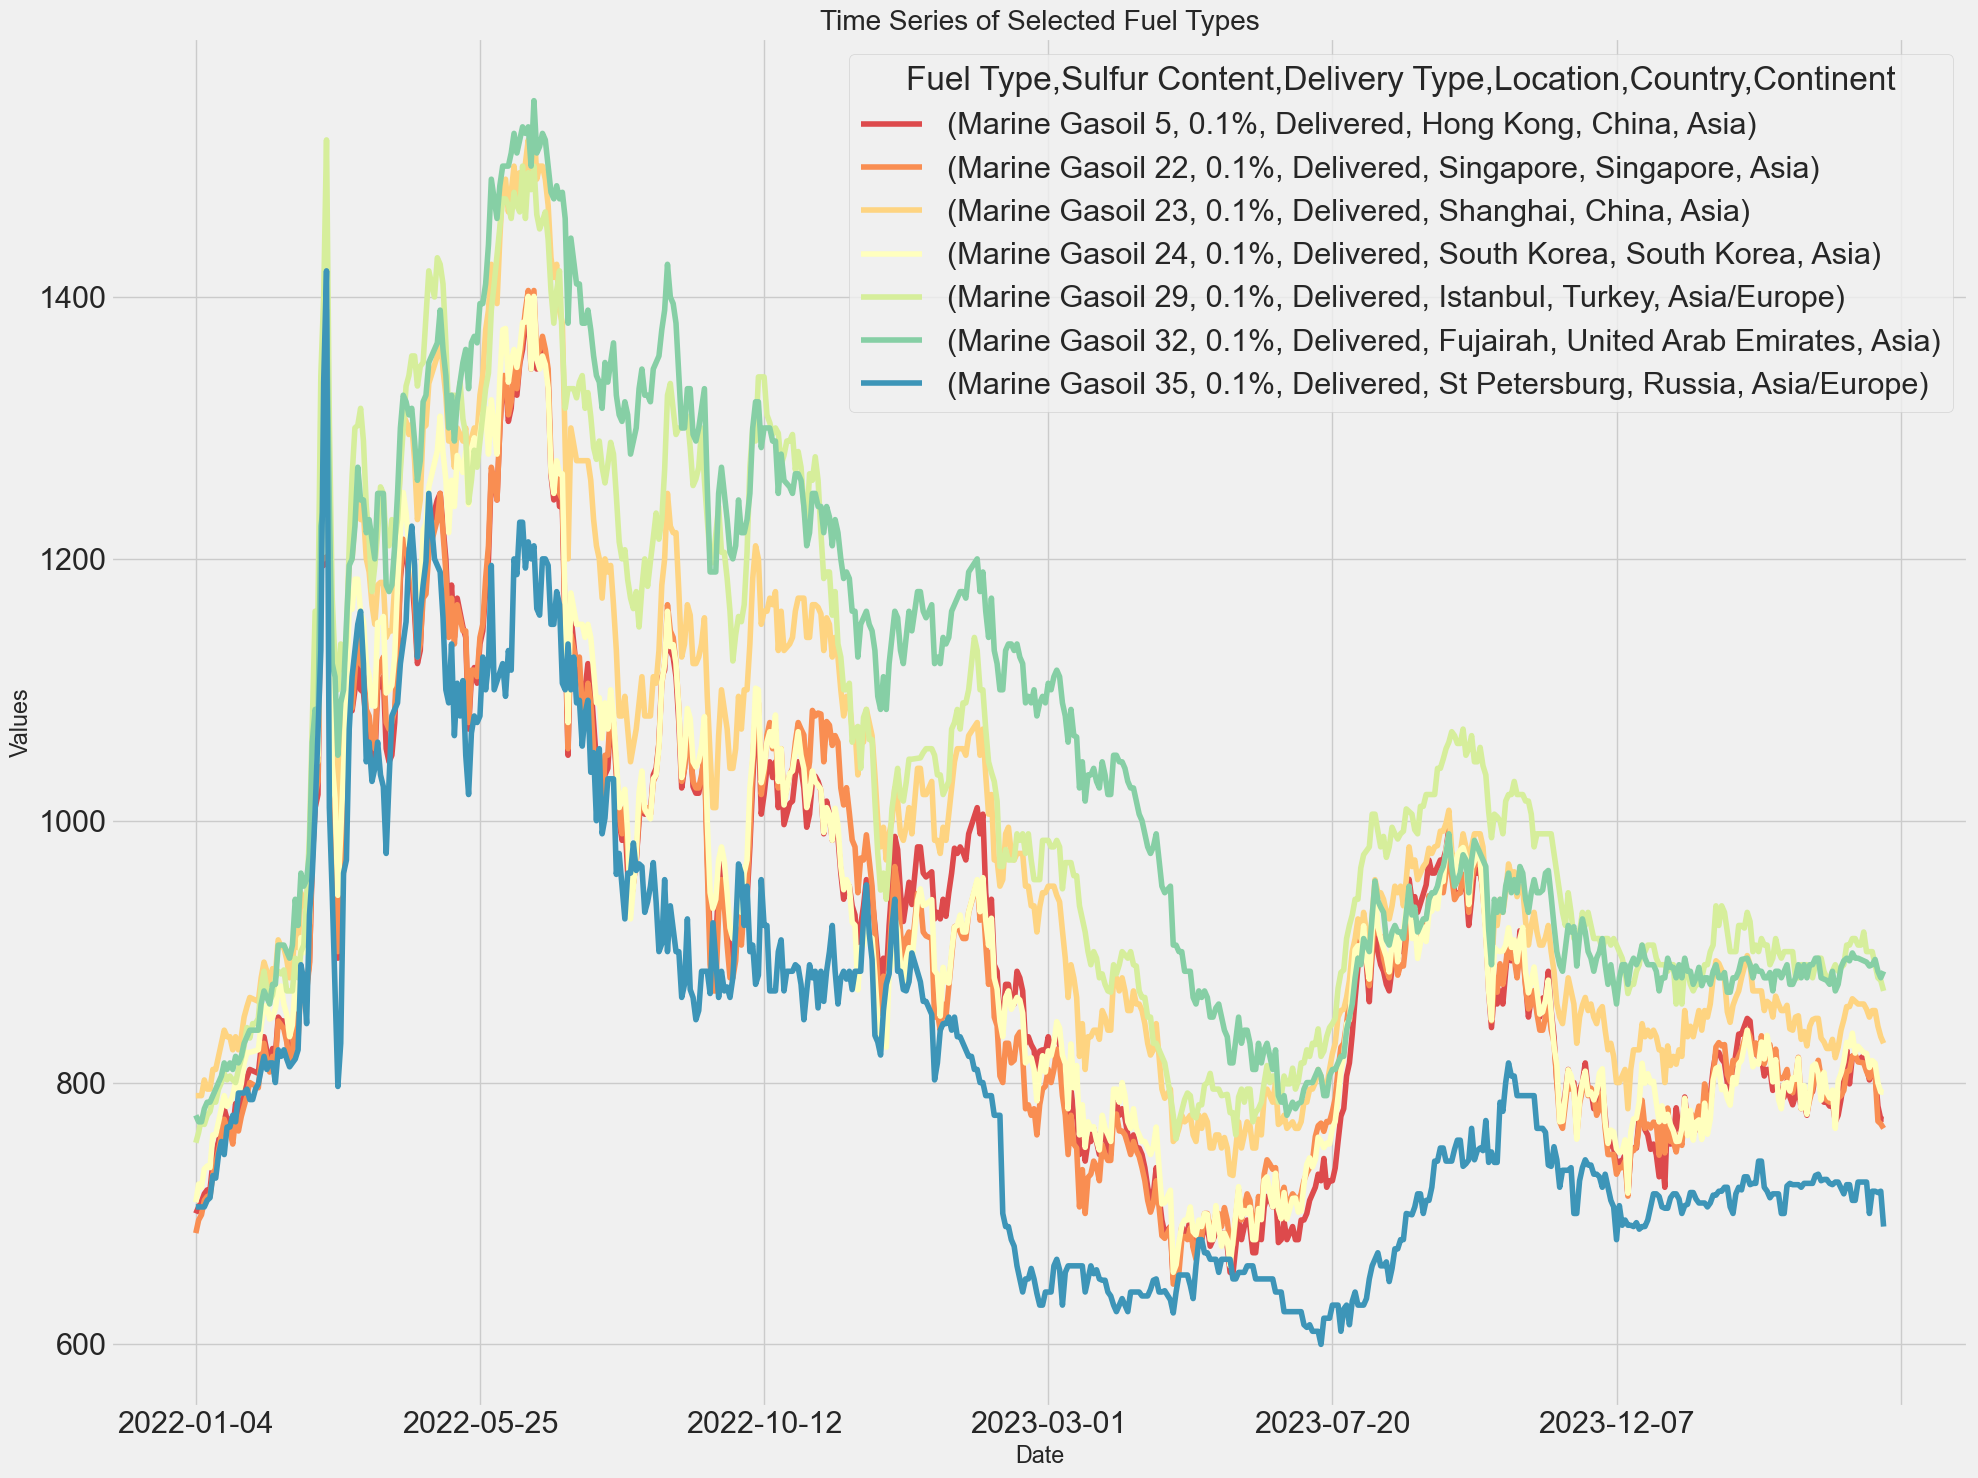

In [48]:
# Set plot parameters
sns.set_palette("Spectral", len(dt_fuel_mg_cond3.columns))
plt.rcParams['figure.figsize'] = (20, 15)

# Plot each column in a single plot
ax = dt_fuel_mg_cond3.plot(legend=True)

# Set title and labels
ax.set_title('Time Series of Selected Fuel Types')
ax.set_xlabel('Date')
ax.set_ylabel('Values')

# Show plot
plt.tight_layout()
plt.show()

In [49]:
# 첫 번째 조건에 맞는 컬럼 필터링
cond1 = dt_fuel_mg.filter(regex='0.1%').columns

# 두 번째 조건에 맞는 컬럼 필터링
cond2 = dt_fuel_mg.filter(regex='Delivered').columns

# 세 번째 조건에 맞는 컬럼 필터링
cond3 = dt_fuel_mg.filter(regex='South America').columns

# 각 조건을 모두 만족하는 컬럼 찾기 (교집합)
common_columns = cond1.intersection(cond2).intersection(cond3)

# 해당 컬럼만 선택
dt_fuel_mg_cond4 = dt_fuel_mg[common_columns]
dt_fuel_mg_cond4

Fuel Type      Marine Gasoil 17 Marine Gasoil 18
Sulfur Content             0.1%             0.1%
Delivery Type         Delivered        Delivered
Location              El Callao       Valparaiso
Country                    Peru            Chile
Continent         South America    South America
2022-01-04                852.0            924.0
2022-01-05                860.0            912.0
2022-01-06                872.0            915.0
2022-01-07                874.0            916.0
2022-01-10                886.0            912.0
...                         ...              ...
2024-04-16               1052.0           1191.0
2024-04-17               1045.0           1184.0
2024-04-18               1038.0           1182.0
2024-04-19               1039.0           1187.0
2024-04-22               1038.0           1189.0

[595 rows x 2 columns]

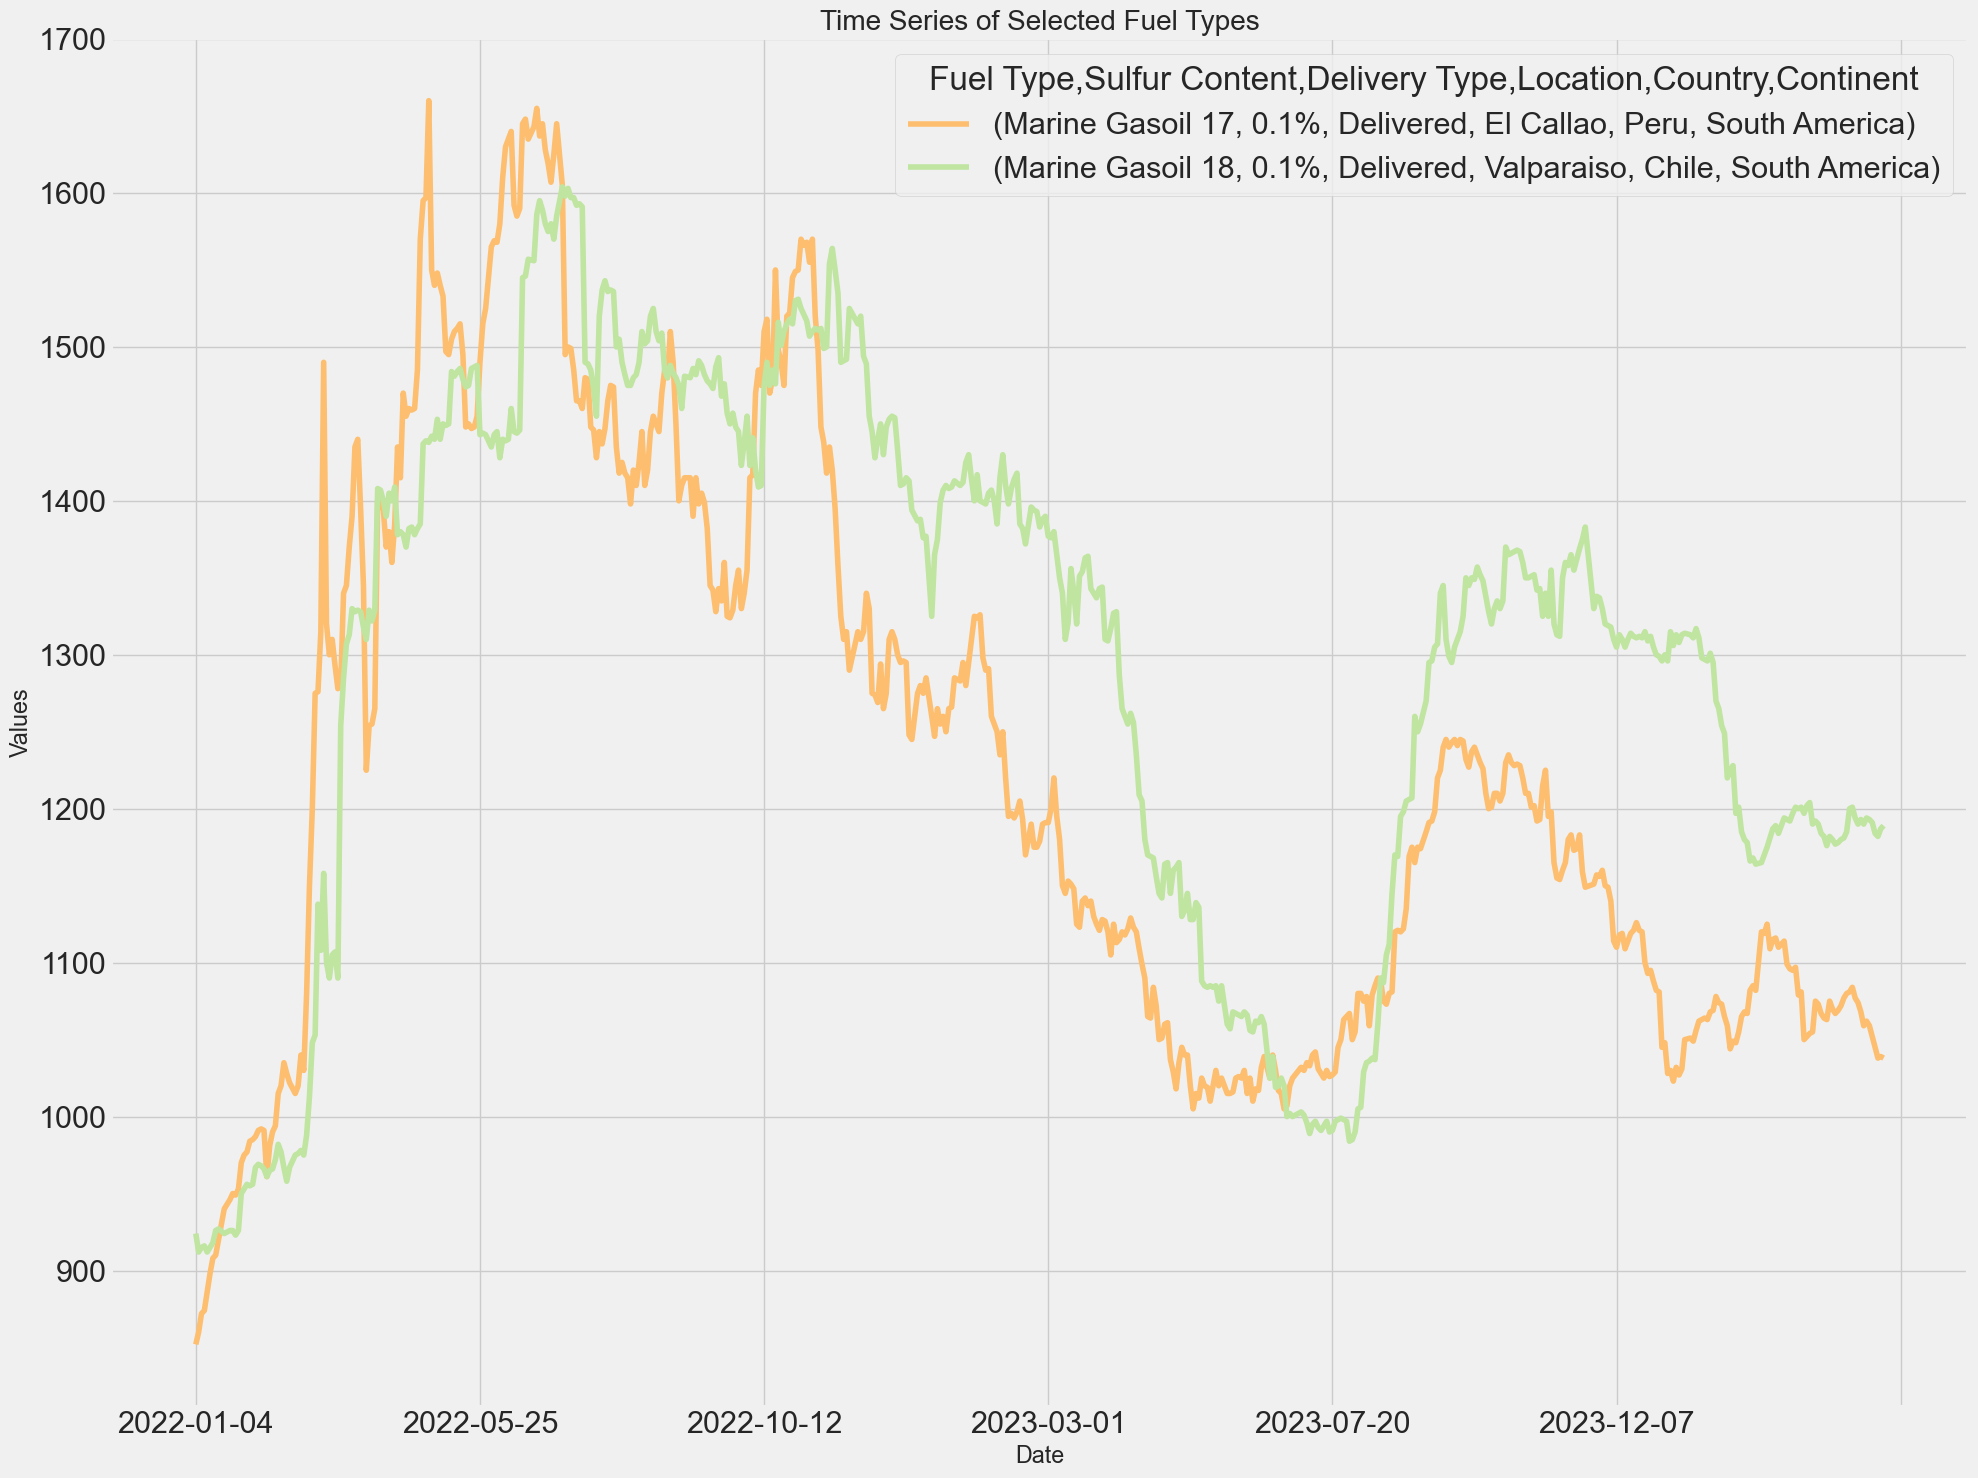

In [50]:
# Set plot parameters
sns.set_palette("Spectral", len(dt_fuel_mg_cond4.columns))
plt.rcParams['figure.figsize'] = (20, 15)

# Plot each column in a single plot
ax = dt_fuel_mg_cond4.plot(legend=True)

# Set title and labels
ax.set_title('Time Series of Selected Fuel Types')
ax.set_xlabel('Date')
ax.set_ylabel('Values')

# Show plot
plt.tight_layout()
plt.show()

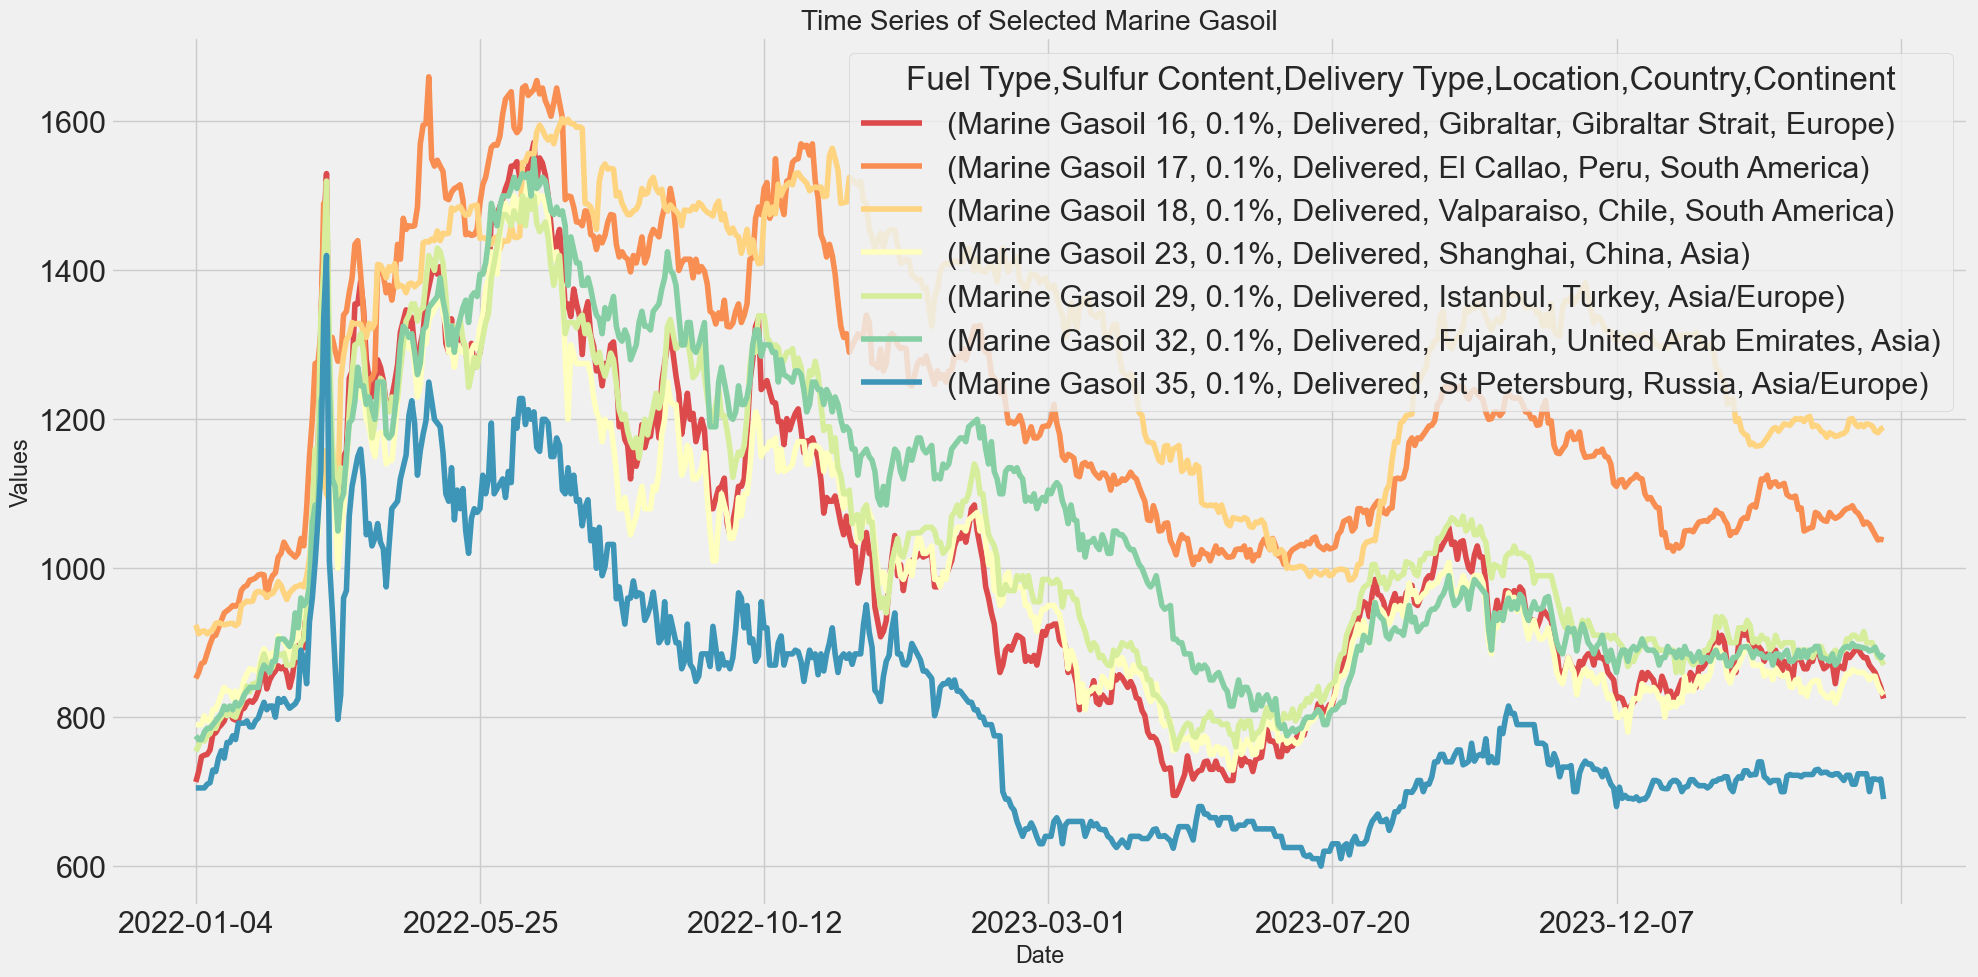

In [53]:
# List of specific columns to visualize
columns_to_plot = ['Marine Gasoil 16', 'Marine Gasoil 17', 'Marine Gasoil 18', 
                   'Marine Gasoil 23', 'Marine Gasoil 29', 'Marine Gasoil 32', 'Marine Gasoil 35']

# Filter the dataframe to include only the specified columns
dt_fuel_mg_selected = dt_fuel_mg[columns_to_plot]

# Set plot parameters
sns.set_palette("Spectral", len(columns_to_plot))
plt.rcParams['figure.figsize'] = (20, 10)

# Plot each column in a single plot
ax = dt_fuel_mg_selected.plot(legend=True)

# Set title and labels
ax.set_title('Time Series of Selected Marine Gasoil')
ax.set_xlabel('Date')
ax.set_ylabel('Values')

# Show plot
plt.tight_layout()
plt.show()

## 최종 분류

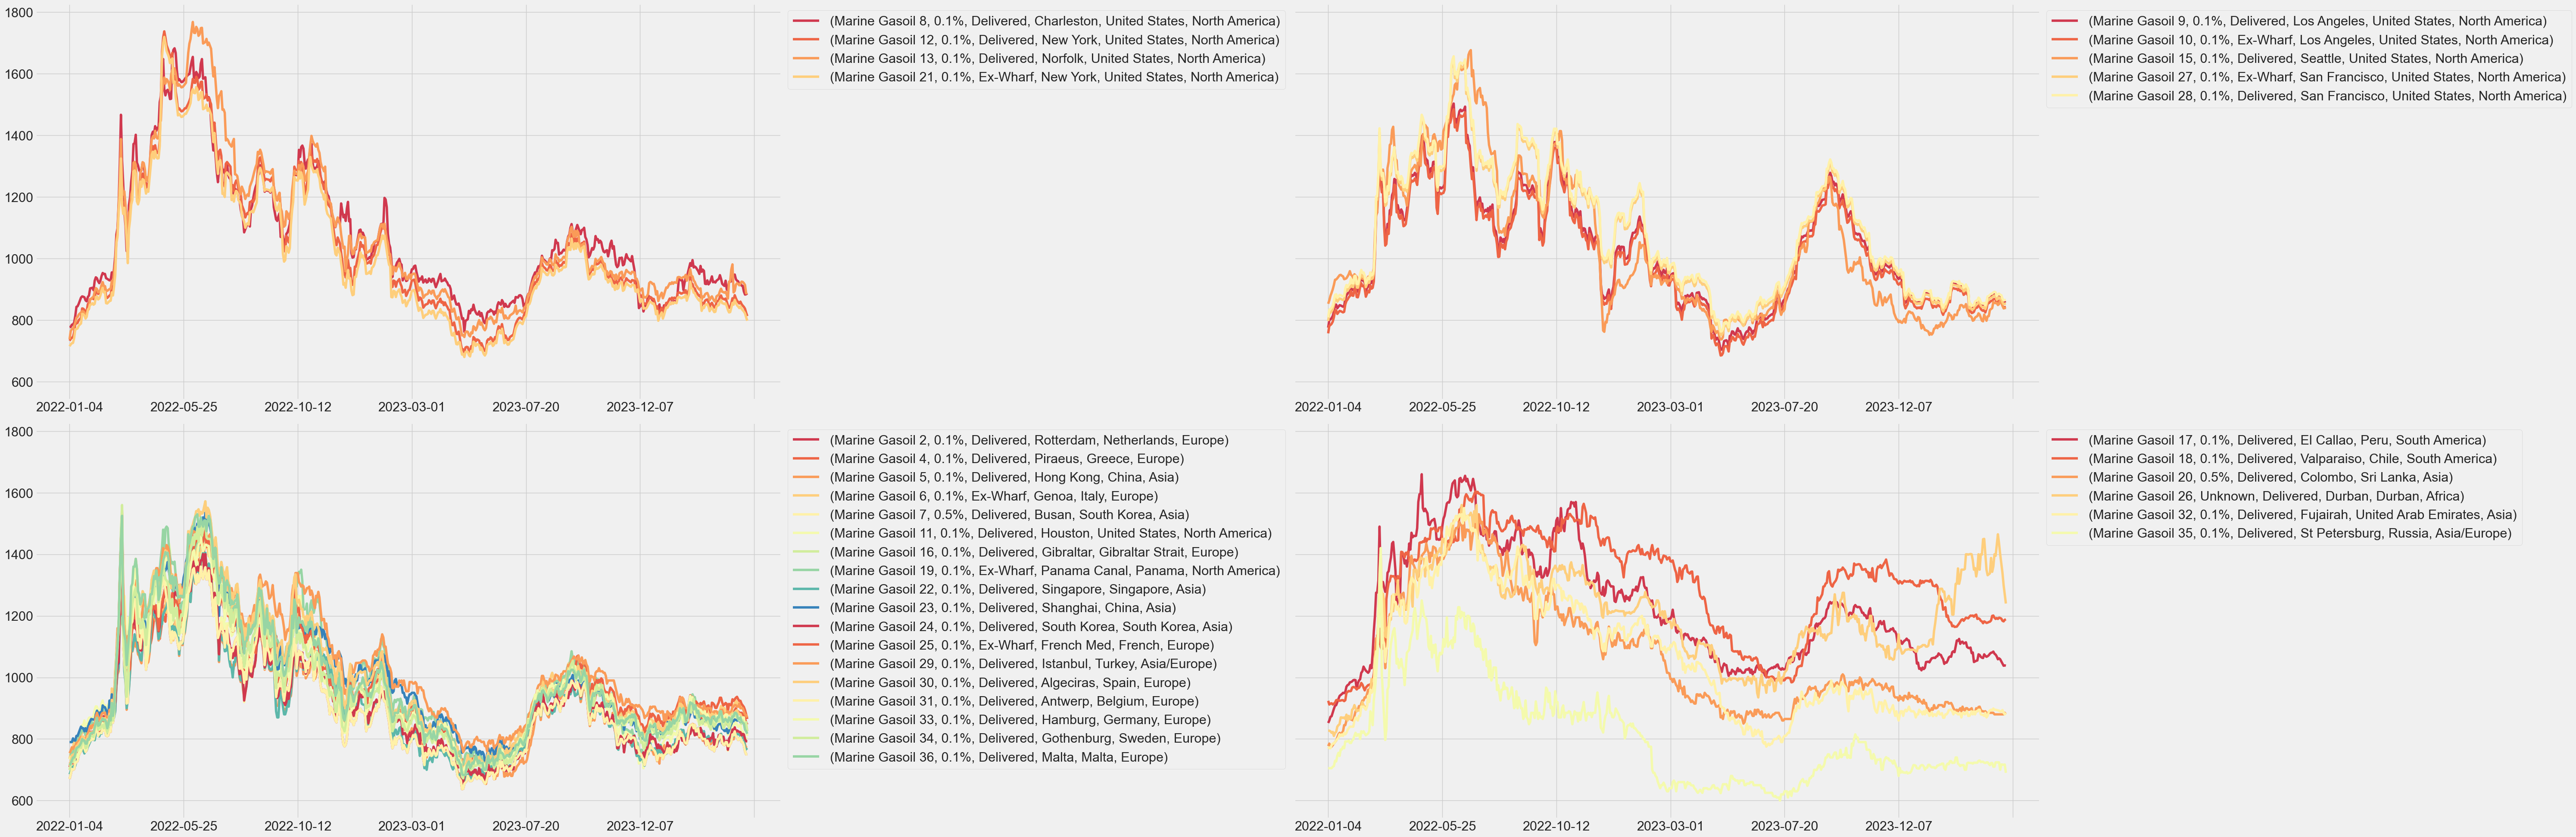

In [81]:
# List of specific columns to visualize for each subplot
columns_to_plot = [
    ['Marine Gasoil 8', 'Marine Gasoil 12', 'Marine Gasoil 13', 'Marine Gasoil 21'],
    ['Marine Gasoil 9', 'Marine Gasoil 10', 'Marine Gasoil 15', 'Marine Gasoil 27', 'Marine Gasoil 28'],
    ['Marine Gasoil 2', 'Marine Gasoil 4', 'Marine Gasoil 5', 'Marine Gasoil 6', 'Marine Gasoil 7', 
     'Marine Gasoil 11', 'Marine Gasoil 16', 'Marine Gasoil 19', 'Marine Gasoil 22', 'Marine Gasoil 23', 'Marine Gasoil 24',
     'Marine Gasoil 25', 'Marine Gasoil 29', 'Marine Gasoil 30', 'Marine Gasoil 31', 'Marine Gasoil 33', 'Marine Gasoil 34', 'Marine Gasoil 36'],
    ['Marine Gasoil 17', 'Marine Gasoil 18', 'Marine Gasoil 20', 'Marine Gasoil 26', 'Marine Gasoil 32', 'Marine Gasoil 35'],
]

# Set plot parameters
sns.set_palette("Spectral", 10)  # Use more colors than needed to ensure variety
plt.rcParams['figure.figsize'] = (60, 20)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each subset of columns in a separate subplot
for i, cols in enumerate(columns_to_plot):
    if cols:  # Only plot if there are columns to plot
        dt_fuel_mg[cols].plot(ax=axes[i], legend=True)
        # axes[i].set_title(f'Columns: {", ".join(cols)}')
        axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside
    else:
        fig.delaxes(axes[i])  # Remove the empty subplot

# Use tight layout
plt.tight_layout()

# Show plot
plt.show()

- 사용했던 컬럼: Marine Gasoil 9 (0.1%, Delivered, Los Angeles, United States, North America)
- 추가 컬럼
    - [같은 형태] Marine Gasoil 27 (0.1%, __Ex-Wharf__, San Francisco, Unitied States, North America)
    - Marine Gasoil 13 (0.1%, Delivered, Norfolk, Unitied States, North America)
    - Marine Gasoil 22 (0.1%, Delivered, Singapore, __Singapore__, __Asia__)
    - Marine Gasoil 36 (0.1%, Delivered, Malta, __Malta__, __Europe__)
    - Marine Gasoil 26 (Unnown, Delivered, Durban, __Durban__, __Africa__)